In [7]:
# add parent dir to syspath
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
root_dir = os.path.dirname(parent_dir)
sys.path.insert(0, root_dir)

In [8]:
from imageGenerators import load_digits, load_realdata
from imageGenerators.imgGen_simple import synth_generator
from models.cyclegan_modified.cyclegan import cyclegan
from evaluationModels.scut_wmn import wmn_helpers

import tensorflow as tf
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import time
import random

import GS_interface
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [9]:
# assert model is running on gpu
from tensorflow.python.client import device_lib
devlist = str(device_lib.list_local_devices())
assert "GPU:0" in devlist

In [10]:
N_IMAGES = 500
N_DIGITS = 5
# Path to i2i-model to use for imagegeneration
CHECKPOINTPATH = Path("D:/m2/savedmodels/checkpoints_cyclegan_modified_midstate")
EPOCH_OF_MODEL = 10

inputshapePath = CHECKPOINTPATH / "inputshape"
cyclegan_shape = [int(s) for s in inputshapePath.read_text().split(",")]

# inputdims of cyclegan
input_height = cyclegan_shape[0]
input_width = cyclegan_shape[1]

# dimensions to scale results to
scale = 4
output_height = int(input_height / scale) 
output_width = int(input_width / scale)


# functions for generating images

In [11]:
def generate_synthethic(labels):        
    # margins between digits, padding around resultimage 
    margins = [30 for _ in range(0, N_DIGITS - 1)]
    padding = (0,0, 1,1) # top,bottom, left, right
    # margin between digits in same column
    vertical_margin = 20
    ####
    # ranges for how far digits can scroll up or down, 0 meaning no scrolling, 0.5 meaning halfway to next digit
    range_normal=(-0.1,0.1)
    range_midstate=(0.3,0.7)
    
    fontnumber = 29 # number of the font to use
    dsPath = Path("C:/Users/andre/Desktop/m/datasets/Chars74K/English/Fnt")
    digitImages = load_digits.load_char74k(dsPath, fonts=[fontnumber - 1])  # index starts at zero, fontnumber at 1
    synthGen = synth_generator(digitImages, vertical_margin)
    images_synthetic = synthGen.generate_images(labels, margins, padding, input_width, input_height, draw_vertical_seperators=False, range_normal=range_normal,range_midstate=range_midstate)
    return images_synthetic

def translate_images(synthImages):
    print("translating synthetic images to realistic images")
    ####
    # load i2i model
    cgModel = cyclegan(cyclegan_shape, checkpoint_path=CHECKPOINTPATH, load_checkpoint_after_epoch=EPOCH_OF_MODEL)
    # prepare input for cgan
    cgan_input = tf.data.Dataset.from_tensor_slices(synthImages)\
                .map(cgModel.preprocess_input, num_parallel_calls=AUTOTUNE)\
                .cache()\
                .batch(1)
    ####
    # predict realistic images
    translated_images = cgModel.gen_AtoB.predict(cgan_input)
    
    # denormalize
    translated_images = (translated_images + 1) * 127.5
    
        
    print("translated images:")
    for i in range(5):
        image = translated_images[i]
        plt.imshow(image.astype(int), cmap="gray")
        plt.show()
        image = synthImages[i]
        plt.imshow(image.astype(int), cmap="gray")
        plt.show()
    
    return translated_images

def get_comparisonSamples(n_images=N_IMAGES, resizeTo=None):
    labels_gen = np.random.randint(0,20,(n_images, N_DIGITS))
    synthImages = generate_synthethic(labels_gen)
    translated_images = translate_images(synthImages)
    if resizeTo != None:
        width = resizeTo[0]
        height = resizeTo[1]
        synthImages = np.array([cv2.resize(image, (width, height)) for image in synthImages])
        translated_images = np.array([cv2.resize(image, (width, height)) for image in translated_images])
    return (synthImages, translated_images)

In [12]:
# load real images
images_easy, _ = wmn_helpers.load_easySamples(output_width, output_height, keepRatio=False, n_toLoad=N_IMAGES)
images_diff_train, _, _, _ = wmn_helpers.load_wmn_traindata(output_width, output_height, keepRatio=False, n_toLoad=N_IMAGES)
# to 1-channel,then to 2d
images_easy = GS_interface.imageset_to2D(images_easy[:,:,:,0])
images_diff_train = GS_interface.imageset_to2D(images_diff_train[:,:,:,0])
# get rlts
easy_rlts = GS_interface.calculate_rlts(images_easy, n=100, printTime=True)
difficult_rlts = GS_interface.calculate_rlts(images_diff_train, n=100, printTime=True)

del images_easy
del images_diff_train

Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100
calculating rlts took 21.984207 seconds
Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100
calculating rlts took 21.252622 seconds


translating synthetic images to realistic images
loaded checkpoint:  D:\m2\savedmodels\checkpoints_cyclegan_modified_midstate\epoch-10
translated images:


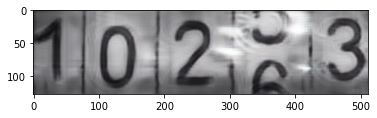

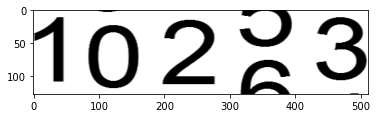

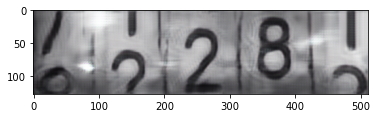

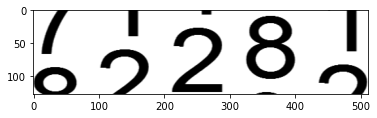

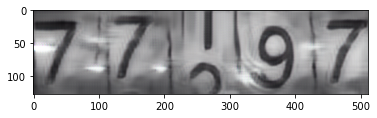

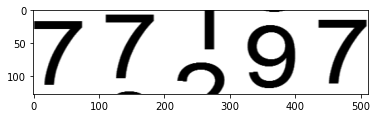

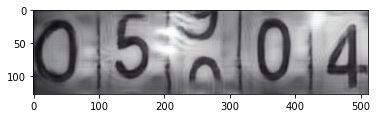

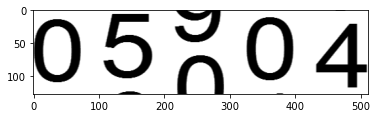

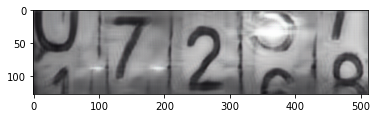

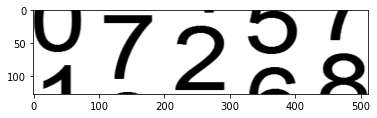

Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100
calculating rlts took 19.929672 seconds
Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100
calculating rlts took 19.919243 seconds


In [13]:
# get rtls for synthetic and translated images
# generate synthetic and translated images
synthetic_images, translated_images = get_comparisonSamples(resizeTo=(output_width, output_height))
synthetic_images = GS_interface.imageset_to2D(synthetic_images) 
translated_images = GS_interface.imageset_to2D(translated_images[:,:,:,0])

synthetic_rlts = GS_interface.calculate_rlts(synthetic_images, n=100, printTime=True)
translated_rlts = GS_interface.calculate_rlts(translated_images, n=100, printTime=True)

In [14]:
# get and print scores
rlts_set = [
    ["synthetic", synthetic_rlts],
    ["translated", translated_rlts],
    ["real_easy", easy_rlts],
    ["real_difficult", difficult_rlts],
]
for i in range(len(rlts_set)):
    for j in range(i, len(rlts_set)):
        score = GS_interface.score(rlts_set[i][1], rlts_set[j][1])
        print("gs(%s, %s)\t\t=%f" % (rlts_set[i][0], rlts_set[j][0], score*1000) )

gs(synthetic, synthetic)		=0.000000
gs(synthetic, translated)		=0.076096
gs(synthetic, real_easy)		=0.865508
gs(synthetic, real_difficult)		=44.571262
gs(translated, translated)		=0.000000
gs(translated, real_easy)		=0.610467
gs(translated, real_difficult)		=44.647358
gs(real_easy, real_easy)		=0.000000
gs(real_easy, real_difficult)		=45.436770
gs(real_difficult, real_difficult)		=0.000000
